# Exercise 06.1
## The Ising Model
In this notebook we study the $1D$ Ising Model for a spin chain of $N_s= 50$ spins. The hamiltonian of the Ising Model is as follows (assuming units such that $\mu_B=1$ and $k_B=1$): 
$$ H = -J\sum_{i=1}^N s_i s_{i+1} -h\sum_{i=1}^N s_i  $$
Where $J$ is the interaction constant and $h$ is the external field. Spins $\{ s_i \}_{i=1,N}$ take values in $\{-1;1\}$. We are assuming periodic boundary conditions, i. e. $s_{N_s+1} = s_{1}$.  
The sign of $J$ determines whether configurations with spins aligned ($J > 0$, ferromagnetic model) or antialigned ($J < 0$, antiferromagnetic model) are favored.  
From now on, we will assume $J = 1$.  
The $1D$ Ising model admits a relatively simple analytical solution we can compare our simulated results with.  
The partition function is: $$ Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N $$
where
$\lambda_{1,2} = e^{\beta J} \cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, and where $\beta= \frac{1}{T}$.  
In the canonical ensemble, the partition function is all we need to determine any quantity of interest exactly. In our case, we are interested in studying the behaviour of the __internal energy__, __heat capacity__, __susceptibility__ and __magnetization__ as functions of __temperature__, in the range $T \in [0.5, 2.0]$.  
All quantities are computed/measured in absence of external field ($h=0$), exception made for the magnetization since the $1D$ Ising model exhibites no ferromagnetic phase, so in absence of external field the magnetization would remain $0$ for all temperatures.

## Markov chains and sampling arbitrary distributions
<p style="border:2px; border-style:solid; border-color:#F5F5F5; padding: 1em; background-color:#F5F5F5">
We measure the properties of the Ising model by sampling spin configurations from distributions that converge towards the Boltzmann distribution, typical of the canonical ensemble. We achieve such a task by ways of two different Markov chains: the Metropolis algorithm and the Gibbs sampling algorithm.  
A Markov chain is a stochastic process that can be used to sample (asyntotically) any arbitrary probability distribution $p(x)$. Basically, an algorithm exploiting a Markov chain generates a random walk: every step $x_i$ of the random walk comes with an associated distribution $d_i (x_i)$. Under the right hypoteses,  $$ \lim _{i \to \infty} d_i \rightarrow p $$
Metropolis and Gibbs algorithms use such processes to sample variables from the distribution $p(x)$, after a (usually small) equilibration time.

## Metropolis algorithm applied to the Ising model
The Metropolis move implemented for the $1D$ Ising model is described now.  
Given a system of spins in a certain configuration $\mu$, in a canonical ensemble with temperature $T=\frac{1}{\beta}$, perform the following steps:
1. Select a random spin $s_i$ in the chain, with value $s_i^\mu$.
2. Let $E_\mu = E(s_i = s_i^\mu)$ be the energy of the configuration and $E_\nu = E(s_i = -s_i^\mu)$ the energy the configuration would have if $s_i$ was flipped and all the other spins remained the same.
3. Flip $s_i$ with probability $A(\nu | \mu) = min[1, e^{-\beta(E_\nu - E_\mu)}]$.
4. Repeat.

It is clear that, if $E_\nu - E_\mu < 0$, then the probability of accepting the move is 1 (i.e. the spin is certainly flipped), while if $E_\nu - E_\mu > 0$, then there is a non-zero probability of rejecting the move.  
In the specific case of a $1D$ spin chain, the explicit expression for the difference in energy is:
$$ E_\nu - E_\mu = 2Js_i^\mu(s_{i-1} + s_{i+1} + h) $$

## Gibbs algorithm applied to the Ising model
The Gibbs sampling method, also known as the heat bath algorithm, works in a similar fashion as the Metropolis algorithm.  
Given a system as before perform the following steps:
1. Select a random spin $s_i$ in the chain.
2. Let $E_\pm = E(s_i = \pm 1)$ be the energy of the configuration with $s_i = \pm 1$ and all the other spins unchanged.
3. Set $s_i = +1 $ with probability $p_+ = \frac{e^{-\beta E_+}}{e^{-\beta E_+} + e^{-\beta E_-}}$ and $s_i = -1 $ with probability $p_- = \frac{e^{-\beta E_-}}{e^{-\beta E_+} + e^{-\beta E_-}} = 1 - p_+$
4. Repeat.

Notice that, differently from the Metropolis algorithm, the probability of accepting the move is __always__ 1 (even if the new value of $s_i$ is equal to the old one, it still counts as an accepted move).  
For a $1D$ spin chain, the explicit expression for the probabilities is:
$$ p_{\pm} = \frac{1}{1 + exp(\mp2\beta [J(s_{i-1}+s_{i+1}) + h])} $$ 

## Equilibration of the system
As stated above, Markov chains sample the desired distribution properly only after some equilibration time, after which the sampled probabilities are sufficiently close to the asymptotic one. One key factor that determines the speed of such convergence (and thus the efficiency of the simulation) is the starting configuration.  
In our simulation, we start from a configuration with uncorrelated spins, i.e. a configuration compatible with a system at infinite temperature.  
Making the simulation start at such a configuration works for high temperatures, that would converge quite fast, but would be a disaster for systems at lower temperatures, that would take quite long to reach equilibrium.  
We alleviate this problem by using the uncorrelated configuration, that we will call $\mu_0$, as a starting configuration for the simulation with the highest temperature $T_1$ (in our case $T_1=2.0$).  
After some (short) equilibration time, we measure the properties we like and, in the end, we get a new configuration compatible with out highest temperature, called $\mu_1$. Now, we feed this configuration $\mu_1$ as the starting configuration of the next simulation, that has a slightly lower temperature, and we wait the same equilibration time, and so on, iteratively, until we reach the lowest temperature.  
In this way, we don't have to worry about adjusting the number of equilibration steps according to how unlikely the fully uncorrelated configuration is with respect to the thermal distribution we want to sample.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
# Define an array of 40 temperatures ranging from 0.5 to 2.0
temps = np.linspace(0.5, 2.0, 40)

# Define a list of strings representing different simulation methods
methods = ["Metro", "Gibbs"]

# Define the number of blocks
n_blocks = 30


## Parameters of simulation
The plots display the results of the simulation, obtained either with Metropolis or Gibbs algorithm, and compare them with the analytical formulas. A $\chi^2$ test is also computed. Each point on the graph is a progressive average with its error on $N = 30$ blocks, each of which consists of $M=10^5$ Monte Carlo steps. A step is intended as $N_s$ consecutive applications of the Metropolis/Gibbs move described above, so that on average after each Monte Carlo step the full spin chain has been updated.  
Before measuring the properties of the system, the configuration is let equilibrate from the starting configuration for $n = 2 \times 10^5$ Monte Carlo steps.  
The range of temperatures $[0.5, 2.0]$ is divided in 39 subintervals, so that the properties are evaluated at 40 different values of $T$.

## Internal Energy $U(N, T)$

From now on, $N$ is the number of spins.
The statistical definition of internal energy is: $$ U(N, T) = \sum_{ \{ s_i \} } H \frac{e^{-\beta H}}{Z} $$
Tha coincides with: $$ U(N, T) = \langle H \rangle $$
The analytical solution is: $$ U(N, T) = -\frac{\partial \ln Z}{\partial \beta} \underset{h=0}= -JN \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl) $$

In [6]:
# Analytic solution
betas = 1./temps
J = 1.
Ns = 50
th = np.tanh(J/temps)
thN= th**Ns
ch = 1/th
energy = -Ns*J*( th + ch*thN )/( 1 + thN )

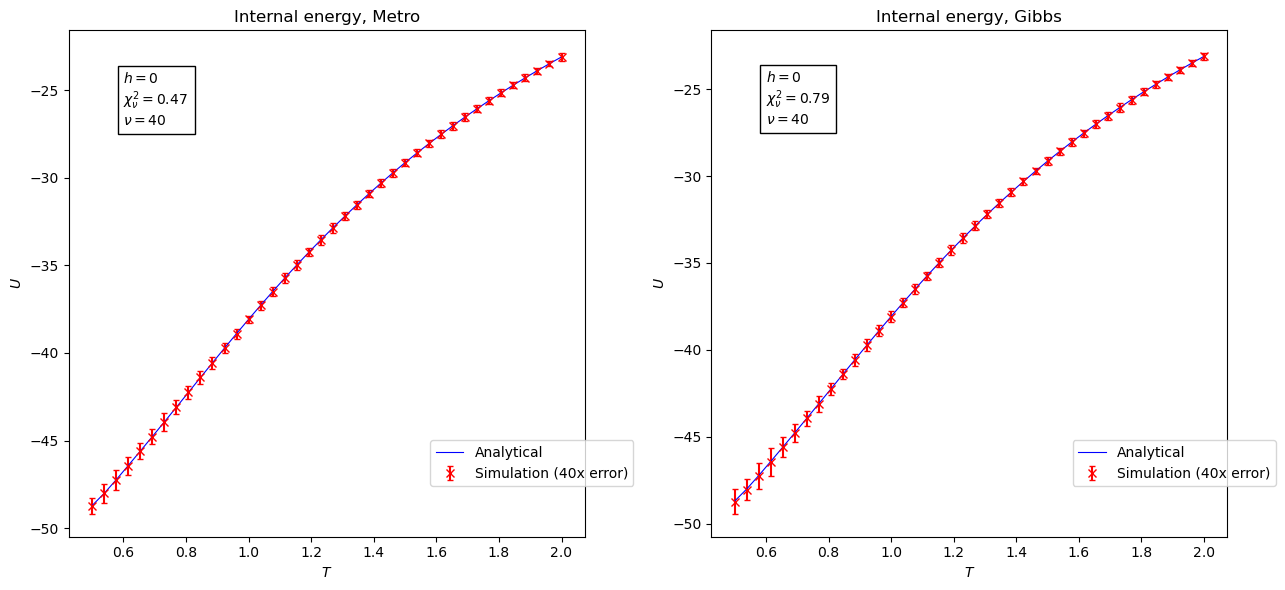

In [7]:
# Define the dimensions of the plot
fig, axx = plt.subplots(1, 2, figsize=(13, 6), tight_layout=True)

# Initialize counter for subplot indexing
i=0

# Loop through different methods
for method in methods:
    ax = axx[i]  # Select subplot
    averages=np.zeros(dimension)  # Array to store average values
    errors=np.zeros(dimension)    # Array to store errors
    
    # Loop through different temperatures
    for j in range(dimension):
        filename=f"{method}"+f"{format(temps[j], '.3f')}"+"/total_energy.dat"  # Construct filename
        appo_av, appo_err=np.loadtxt(filename, usecols=(2, 3), skiprows=n_blocks, unpack=True, max_rows=1)  # Load data
        averages[j] = Ns*appo_av  # Compute average energy
        errors[j] = Ns*appo_err    # Compute error
    
    # Plot the simulation data with error bars
    ax.errorbar(temps, averages, yerr=40*errors, capsize=2.5, marker="x", linestyle=" ", color="r", label="Simulation (40x error)")
    
    # Plot the analytical function
    ax.plot(temps, energy, color="blue", linewidth="0.8", label="Analytical")
    
    # Compute chi2
    observed = averages
    variances = errors**2
    squared_distances = (observed - energy)**2 / variances
    chi2 = np.sum(squared_distances) / (squared_distances.shape[0])
    
    # Set plot properties
    ax.set_title(r"Internal energy, "+method)
    ax.set_xlabel("$T$")
    ax.set_ylabel(r"$U$")
    
    # Add box with chi2 value to the plot
    ax.text(0.6, -27, 
            f"$h=0$ \n"+r"$\chi_{\nu}^2$"+f"$={format(chi2, '.2f')}$ \n"+r"$\nu=40$ ", 
            bbox=dict(facecolor='white', alpha=1))
    
    # Add legend to the plot
    ax.legend(loc=(0.7, 0.1))
    
    # Increment subplot index
    i+=1


## Heat Capacity $C(N, T)$
The heat capacity is defined as: $$ C(N, T) = \frac{\partial U(N,T)}{\partial T} $$
that corresponds to: $$ C(N, T) = \beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right) $$
The analytical solution is: $$ C(N, T) \underset{h=0}= 
N(\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\} $$

In [8]:
#Analytical solution
heat=Ns*((betas*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

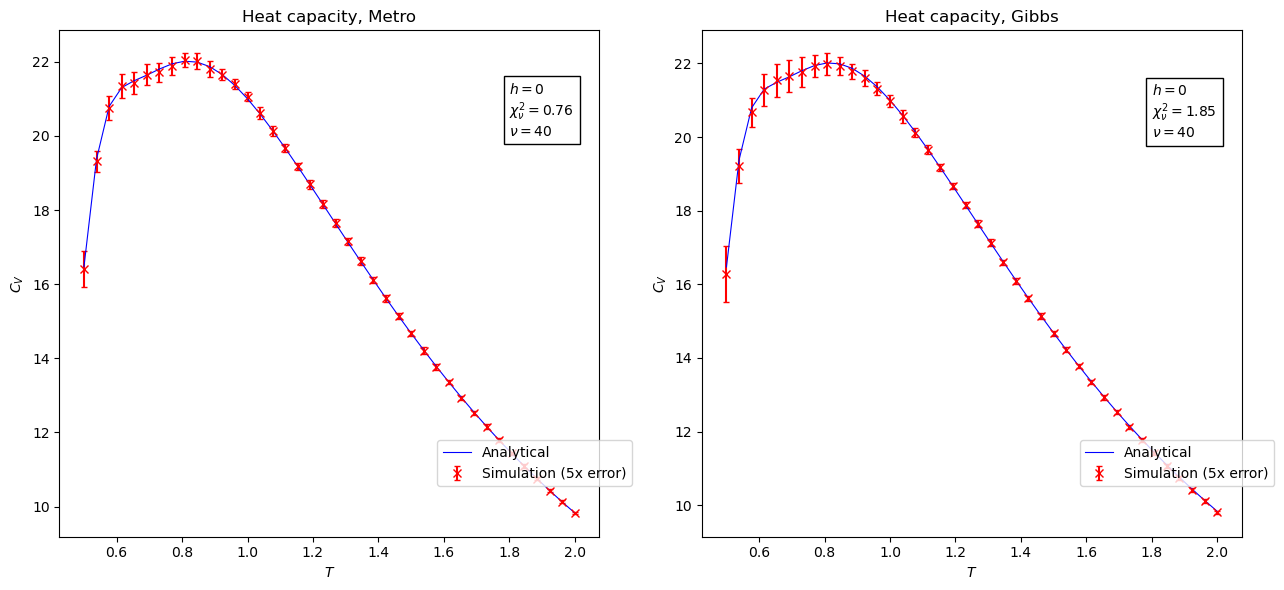

In [9]:
# Define the dimensions of the plot
fig, axx = plt.subplots(1, 2, figsize=(13, 6), tight_layout=True)

# Initialize counter for subplot indexing
i=0

# Loop through different methods
for method in methods:
    ax = axx[i]  # Select subplot
    averages=np.zeros(dimension)  # Array to store average values
    errors=np.zeros(dimension)    # Array to store errors
    
    # Loop through different temperatures
    for j in range(dimension):
        filename=f"{method}"+f"{format(temps[j], '.3f')}"+"/specific_heat.dat"  # Construct filename
        appo_av, appo_err=np.loadtxt(filename, usecols=(2, 3), skiprows=n_blocks, unpack=True, max_rows=1)  # Load data
        averages[j] = appo_av  # Compute average heat capacity
        errors[j] = appo_err    # Compute error
    
    # Plot the simulation data with error bars
    ax.errorbar(temps, averages, yerr=5*errors, capsize=2.5, marker="x", linestyle=" ", color="r", label="Simulation (5x error)")
    
    # Plot the analytical function
    ax.plot(temps, heat, color="blue", linewidth="0.8", label="Analytical")
    
    # Compute chi2
    observed = averages
    variances = errors**2
    squared_distances = (observed - heat)**2 / variances
    chi2 = np.sum(squared_distances) / (squared_distances.shape[0])
    
    # Set plot properties
    ax.set_title(r"Heat capacity, "+method)
    ax.set_xlabel("$T$")
    ax.set_ylabel(r"$C_V$")
    
    # Add box with chi2 value to the plot
    ax.text(1.8, 20, 
            f"$h=0$ \n"+r"$\chi_{\nu}^2$"+f"$={format(chi2, '.2f')}$ \n"+r"$\nu=40$ ", 
            bbox=dict(facecolor='white', alpha=1))
    
    # Add legend to the plot
    ax.legend(loc=(0.7, 0.1))
    
    # Increment subplot index
    i+=1


## Magnetization $ M(N, T, h) $
The magnetization of the system is defined as: $$ M(N,T,h) = \sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} $$ 
which corresponds to: $$ M(N,T,h) = \left\langle \sum_{i=1,N}s_i \right\rangle $$ 
The analytical solution is: $$ M(N,T,h) = T \frac{\partial \ln Z}{\partial h} = N\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr] $$ 

In [10]:
#Analytical solution
h=0.02 #external field
l1 = np.exp(betas*J)*np.cosh(betas*h)+np.sqrt(np.exp(2*betas*J)*np.cosh(betas*h)*np.cosh(betas*h)-2*np.sinh(2*betas*J))
l2 = np.exp(betas*J)*np.cosh(betas*h)-np.sqrt(np.exp(2*betas*J)*np.cosh(betas*h)*np.cosh(betas*h)-2*np.sinh(2*betas*J))
Z = l1**Ns + l2**Ns
magnet = Ns*(np.exp(betas*J)*np.sinh(betas*h)*((l1**(Ns-1))*(1+np.exp(betas*J)*np.cosh(betas*h)/np.sqrt(np.exp(2*betas*J)*np.cosh(betas*h)*np.cosh(betas*h)-2*np.sinh(2*betas*J))) 
        + (l2**(Ns-1))*(1-np.exp(betas*J)*np.cosh(betas*h)/np.sqrt(np.exp(2*betas*J)*np.cosh(betas*h)*np.cosh(betas*h)-2*np.sinh(2*betas*J)))))/(Z)

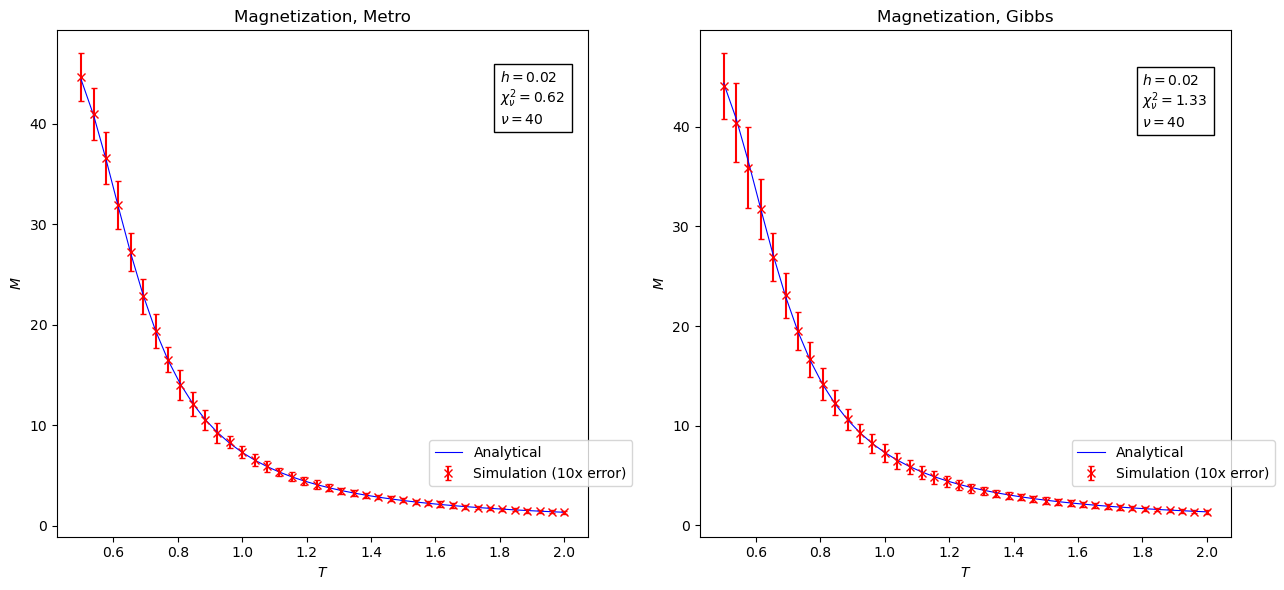

In [11]:
# Define the dimensions of the plot
fig, axx = plt.subplots(1, 2, figsize=(13, 6), tight_layout=True)

# Initialize counter for subplot indexing
i=0

# Loop through different methods
for method in methods:
    ax = axx[i]  # Select subplot
    averages=np.zeros(dimension)  # Array to store average values
    errors=np.zeros(dimension)    # Array to store errors
    
    # Loop through different temperatures
    for j in range(dimension):
        filename=f"{method}"+f"{format(temps[j], '.3f')}"+"/magnetization.dat"  # Construct filename
        appo_av, appo_err=np.loadtxt(filename, usecols=(2, 3), skiprows=n_blocks, unpack=True, max_rows=1)  # Load data
        averages[j] = appo_av  # Compute average magnetization
        errors[j] = appo_err    # Compute error
    
    # Plot the simulation data with error bars
    ax.errorbar(temps, averages, yerr=10*errors, capsize=2.5, marker="x", linestyle=" ", color="r", label="Simulation (10x error)")
    
    # Plot the analytical function
    ax.plot(temps, magnet, color="blue", linewidth="0.8", label="Analytical")
    
    # Compute chi2
    observed = averages
    variances = errors**2
    squared_distances = (observed - magnet)**2 / variances
    chi2 = np.sum(squared_distances) / (squared_distances.shape[0])
    
    # Set plot properties
    ax.set_title(r"Magnetization, "+method)
    ax.set_xlabel("$T$")
    ax.set_ylabel(r"$M$")
    
    # Add box with chi2 value to the plot
    ax.text(1.8, 40, 
            f"$h=0.02$ \n"+r"$\chi_{\nu}^2$"+f"$={format(chi2, '.2f')}$ \n"+r"$\nu=40$ ", 
            bbox=dict(facecolor='white', alpha=1))
    
    # Add legend to the plot
    ax.legend(loc=(0.7, 0.1))
    
    # Increment subplot index
    i+=1



## Susceptibility $\chi (N, T)$
The magnetic susceptibility is defined as: $$ \chi (N, T) = \frac{\partial M}{\partial h} $$
which corresponds to: $$ \chi (N, T) \underset{h=0}= \beta \left\langle M^2 \right\rangle$$
The analytical solution is: $$ \chi (N, T) \underset{h=0}= N \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl) $$

In [12]:
#Analytical solution
X = Ns*betas*np.exp(2*betas*J)*(1-thN)/(1+thN)

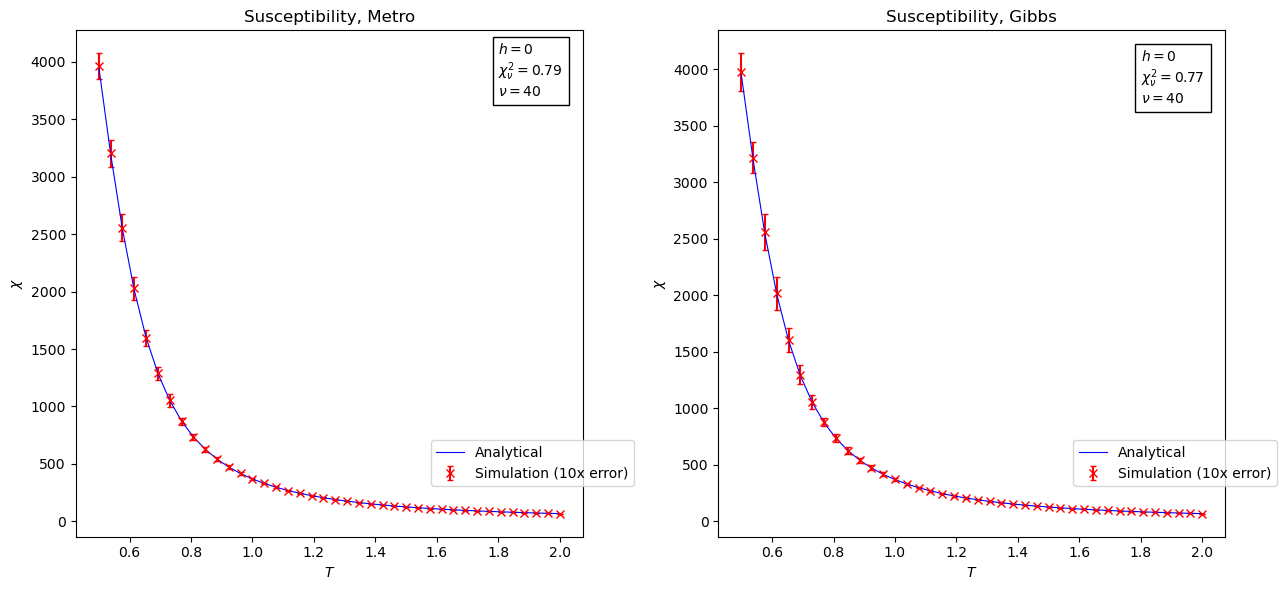

In [13]:
# Define the dimensions of the plot
fig, axx = plt.subplots(1, 2, figsize=(13, 6), tight_layout=True)

# Initialize counter for subplot indexing
i=0

# Loop through different methods
for method in methods:
    ax = axx[i]  # Select subplot
    averages=np.zeros(dimension)  # Array to store average values
    errors=np.zeros(dimension)    # Array to store errors
    
    # Loop through different temperatures
    for j in range(dimension):
        filename=f"{method}"+f"{format(temps[j], '.3f')}"+"/susceptibility.dat"  # Construct filename
        appo_av, appo_err=np.loadtxt(filename, usecols=(2, 3), skiprows=n_blocks, unpack=True, max_rows=1)  # Load data
        averages[j] = appo_av  # Compute average susceptibility
        errors[j] = appo_err    # Compute error
    
    # Plot the simulation data with error bars
    ax.errorbar(temps, averages, yerr=10*errors, capsize=2.5, marker="x", linestyle=" ", color="r", label="Simulation (10x error)")
    
    # Plot the analytical function
    ax.plot(temps, X, color="blue", linewidth="0.8", label="Analytical")
    
    # Compute chi2
    observed = averages
    variances = errors**2
    squared_distances = (observed - X)**2 / variances
    chi2 = np.sum(squared_distances) / (squared_distances.shape[0])
    
    # Set plot properties
    ax.set_title(r"Susceptibility, "+method)
    ax.set_xlabel("$T$")
    ax.set_ylabel(r"$\chi$")
    
    # Add box with chi2 value to the plot
    ax.text(1.8, 3700, 
            f"$h=0$ \n"+r"$\chi_{\nu}^2$"+f"$={format(chi2, '.2f')}$ \n"+r"$\nu=40$ ", 
            bbox=dict(facecolor='white', alpha=1))
    
    # Add legend to the plot
    ax.legend(loc=(0.7, 0.1))
    
    # Increment subplot index
    i+=1